In [ ]:
from langchain import Chain, tools

# Define a tool to fetch the finance news
class YahooFinanceNewsTool:
    def __init__(self, api_key):
        self.api_key = api_key
        
    def get_news(self):
        # Your existing API call logic here
        response = requests.get(url, headers={"Authorization": f"Bearer {self.api_key}"})
        return response.json()

# Instantiate the tool
finance_tool = YahooFinanceNewsTool(api_key='YOUR_API_KEY')

# Create a LangChain to fetch and format news
news_chain = Chain([...], tools=[finance_tool])

🔍 `data_retrieval`에 할당된 State 타입(T): DataState
🔍 `data_cleaning`에 할당된 State 타입(T): DataState
🔍 `news_sentiment`에 할당된 State 타입(T): FinanceState
🔍 `market_trend`에 할당된 State 타입(T): FinanceState
🔍 `investment_strategy`에 할당된 State 타입(T): FinanceState
🔍 `report_generation`에 할당된 State 타입(T): ReportState
🔍 `summary_extraction`에 할당된 State 타입(T): ReportState


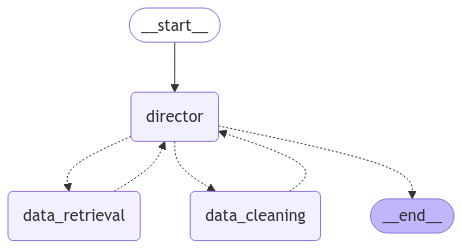

In [6]:
# 표준 라이브러리
import os
import requests
from IPython.display import Image, display
# 서드파티 라이브러리
import streamlit as st
import openai
from dotenv import load_dotenv
from pydantic import BaseModel
from typing import TypedDict, List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Any,Generic 


# LangChain 및 LangGraph 관련 라이브러리
from langchain_openai import OpenAI
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
from langchain_core.language_models.chat_models import BaseChatModel

# LangGraph 관련 라이브러리
from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults

from agents.agent_library import agent_configs, AgentConfig

# 환경 변수 로드
load_dotenv()

# 환경 변수에서 키 가져오기
openai_api_key = os.getenv("OPENAI_API_KEY")
alpha_vantage_key = os.getenv("ALPHA_VANTAGE_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

MODEL_NAME = "gemma2-9b-it"


# State 정의
class DataState(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

# State 정의
class FinanceState(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

# State 정의
class ReportState(TypedDict):
    messages: Annotated[list, add_messages]
    next: str


T = TypeVar("T", DataState, FinanceState, ReportState)

agent_state_map: Dict[str, Type] = {
    "data_retrieval": DataState,
    "data_cleaning": DataState,
    "news_sentiment": FinanceState,
    "market_trend": FinanceState,
    "investment_strategy": FinanceState,
    "report_generation" :ReportState,
    "summary_extraction" : ReportState
}


# make_supervisor_node 함수 정의
def make_supervisor_node(
        MODEL_NAME: str, 
        members: List[str], 
        system_prompt: str, 
        state_type: Type[T] ) -> str:
    
    options_for_next  = ["FINISH"] + members

    # ✅ 구조화된 응답 스키마 정의
    class Router(TypedDict):
        next: Literal[*options_for_next]

    def supervisor_node(state: T) -> Command[Literal[*members, "__end__"]]:
        # ✅ 타입 체크 추가 (런타임에서 올바른 State인지 확인)
        if not isinstance(state, state_type):
            raise TypeError(f"⚠ `state`가 예상한 타입이 아닙니다. "
                            f"예상: {state_type.__name__}, 전달된 타입: {type(state).__name__}")

        # system_prompt를 메시지 맨 앞에 추가한 후, 상태에 저장된 메시지와 결합
        messages = [{"role": "system", "content": system_prompt}] + state["messages"]
        
        llm = ChatGroq(
            model=MODEL_NAME, temperature=0,
            max_tokens=None, timeout=None,
            max_retries=2,
        )

        # ✅ LLM 호출하여 구조화된 응답 획득
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        
        if goto == "FINISH":
            goto = END
        return Command(goto=goto, update={"next": goto})
    
    return supervisor_node



class AgentMaker(Generic[T]):
    def __init__(self, model_name: str, agent_configs: Dict[str, AgentConfig], agent_state_map: Dict[str, Type[T]]):
        self.llm = ChatGroq(model=model_name, temperature=0)
        self.agent_configs = agent_configs  # 설정 파일 저장
        self.agent_state_map = agent_state_map  # 외부에서 State 매핑을 받음

    def create_agent(self, config: AgentConfig):
        """AgentConfig 타입을 받아서 에이전트 생성"""
        return create_react_agent(self.llm, tools=config["tools"], prompt=config.get("prompt"))

    def create_agent_node(self, agent, name: str, state_type: Type[T]) -> Callable[[T], Command[Literal["director"]]]:
        """
        특정 Agent를 위한 노드 생성. `T`를 활용하여 올바른 `State` 타입을 지정.
        """

        def agent_node(state: T) -> Command[Literal["director"]]:
            # ✅ LangChain에서 `state`를 자동으로 넘겨주므로 타입 검증 추가
            if not isinstance(state, state_type):
                raise TypeError(f"⚠ `state`가 예상한 타입이 아닙니다. "
                                f"예상: {state_type.__name__}, 전달된 타입: {type(state).__name__}")

            # ✅ LangChain이 `State`를 자동으로 주입하여 실행
            result = agent.invoke(state)
            return Command(
                update={
                    "messages": [
                        HumanMessage(content=result["messages"][-1].content, name=name)
                    ]
                },
                goto="director",
            )

        return agent_node

    def create_agent_and_node(self, name: str) -> Tuple[Type[T], Callable[[T], Command[Literal["director"]]]]:
        """
        :param name: agent_configs에서 찾을 에이전트 이름
        :return: (생성된 agent, 생성된 node)
        """
        if name not in self.agent_configs:
            raise ValueError(f"'{name}' 설정을 찾을 수 없습니다. (config에 존재하는 키 확인 필요)")

        if name not in self.agent_state_map:
            raise ValueError(f"'{name}'에 대한 State 타입이 정의되지 않았습니다. (agent_state_map 확인 필요)")

        #  개별 에이전트의 State 타입을 가져옴
        state_type = self.agent_state_map[name]

        #  `T`가 올바르게 매핑되었는지 확인
        print(f"🔍 `{name}`에 할당된 State 타입(T): {state_type.__name__}")

        #  에이전트 생성
        agent = self.create_agent(self.agent_configs[name])

        #  해당 State 타입을 처리할 수 있는 Agent Node 생성
        node = self.create_agent_node(agent, name, state_type)

        return agent, node

# 각 Supervisor 노드가 호출할 에이전트 노드 리스트 정의
team_node_list = ["data_team", "financial_team", "reporter_team"]

data_agent_node_list = ["data_retrieval", "data_cleaning"]
financial_agent_node_list = ["news_sentiment", "market_trend", "investment_strategy"]
reporter_agent_node_list = ["report_generation", "summary_extraction"]

# 각 Suppervisor 노드가 사용할 프롬프트트
# director_system_prompt = f""" \n
#     You are a director tasked with managing a conversation between the \n
#     following workers: {team_node_list}. Given the following user request,\n
#     respond with the worker to act next. Each worker will perform a \n
#     task and respond with their results and status. When finished, \n
#     respond with FINISH. """

director_system_prompt = f""" \n
    You are a director tasked with managing a conversation between the \n
    following workers: {team_node_list}. Given the following user request,\n
    respond with the worker to act next. Each worker will perform a \n
    task and respond with their results and status. When finished, \n
    respond with FINISH.  

    If data collection is required, assign the task to the data_team. \n
    If financial analysis is needed, assign the task to the financial_team. \n
    If report writing is necessary, assign the task to the reporter_team.  
"""



data_director_system_prompt = f""" \n
    You are a director tasked with managing a conversation between the \n
    following workers: {data_agent_node_list}. Given the following user request,\n
    respond with the worker to act next. Each worker will perform a \n
    task and respond with their results and status. When finished, \n
    respond with FINISH.  

"""

finance_director_system_prompt = f""" \n
    You are a director tasked with managing a conversation between the \n
    following workers: {financial_agent_node_list}. Given the following user request,\n
    respond with the worker to act next. Each worker will perform a \n
    task and respond with their results and status. When finished, \n
    respond with FINISH.  

"""

reporter_director_system_prompt = f""" \n
    You are a director tasked with managing a conversation between the \n
    following workers: {reporter_agent_node_list}. Given the following user request,\n
    respond with the worker to act next. Each worker will perform a \n
    task and respond with their results and status. When finished, \n
    respond with FINISH.  

"""

# 각 Supervisor 노드 정의
data_director_agent_node = make_supervisor_node(MODEL_NAME, data_agent_node_list, data_director_system_prompt,state_type=DataState)
financial_director_agent_node = make_supervisor_node(MODEL_NAME, financial_agent_node_list, finance_director_system_prompt,state_type=FinanceState)
report_director_agent_node = make_supervisor_node(MODEL_NAME, reporter_agent_node_list, reporter_director_system_prompt,state_type=ReportState)


# 팩토리 인스턴스 생성
agent_maker = AgentMaker(model_name=MODEL_NAME, agent_configs=agent_configs, agent_state_map=agent_state_map)
# agent_maker = AgentMaker(model_name=MODEL_NAME, agent_configs=agent_configs)

# 에이전트, 노드 생성 
data_retrieval_agent, data_retrieval_node = agent_maker.create_agent_and_node(name="data_retrieval")
data_cleaning_agent, data_cleaning_node = agent_maker.create_agent_and_node(name="data_cleaning")

news_sentiment_agent, news_sentiment_node = agent_maker.create_agent_and_node(name="news_sentiment")
market_trend_agent, market_trend_node = agent_maker.create_agent_and_node(name="market_trend")
investment_strategy_agent, investment_strategy_node = agent_maker.create_agent_and_node(name="investment_strategy")

report_generation_agent, report_generation_node = agent_maker.create_agent_and_node(name="report_generation")
summary_extraction_agent, summary_extraction_node = agent_maker.create_agent_and_node(name="summary_extraction")

# data_team 워크플로우
data_builder = StateGraph(DataState)
data_builder.add_node("director", data_director_agent_node)
data_builder.add_node("data_retrieval", data_retrieval_node)
data_builder.add_node("data_cleaning", data_cleaning_node)

data_builder.add_edge(START, "director")
data_graph = data_builder.compile()




display(Image(data_graph.get_graph().draw_mermaid_png()))

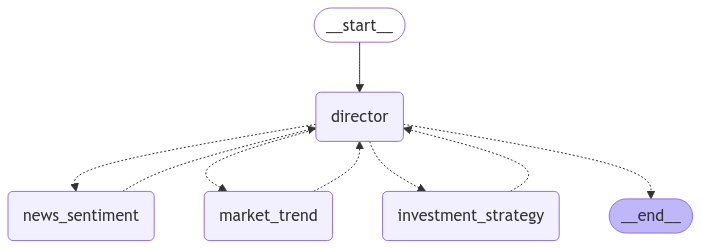

In [7]:
# data_team 워크플로우
finacial_builder = StateGraph(FinanceState)
finacial_builder.add_node("director", financial_director_agent_node)
finacial_builder.add_node("news_sentiment", news_sentiment_node)
finacial_builder.add_node("market_trend", market_trend_node)
finacial_builder.add_node("investment_strategy", data_cleaning_node)

finacial_builder.add_edge(START, "director")
financial_graph = finacial_builder.compile()

display(Image(financial_graph.get_graph().draw_mermaid_png()))